In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.simplefilter("ignore")

### Load in both gapminder and CIRI data

In [2]:
gap = pd.read_csv('../data/GapminderData.csv')
CI = pd.read_csv('../data/CIRI_Data_1981_2011.csv')

In [3]:
# clean and change the key colunmns into string 
gap['country'] = gap['country'].apply(lambda x :x.strip())
gap['country'] = gap['country'].astype('str')
CI['CTRY'] = CI['CTRY'].apply(lambda x :x.strip())
CI['CTRY'] = CI['CTRY'].astype('str')

In [4]:
# Combine the two dataFrames
combined = pd.merge(gap,CI,left_on=['country','Date'],right_on=['CTRY','YEAR'],how = 'inner')

In [5]:
# Replace the -999 (no value), -77 (Country had no government), and -66 (occupied by foreign power) with null
combined[(combined <= -999) | (combined <= -77) | (combined <= -66)] = np.nan

In [6]:
rev_labels = ['Date','ANNUAL_BIRTH_RATE_PER_1000','LIFE_EXP_YEARS','LIFE_EXP_YEARS_F',
              'LIFE_EXP_YEARS_M','CHILD_MORTALITY','GDP_USD','INFLATION_PERCENT','EMPLOYMENT',
              'GIRLS_V_BOYS_EDU','CELL_PHONE_PER_100','HUMAN_DEV_SCORE','DISAP','KILL','POLPRIS',
              'TORT','ASSN', 'FORMOV', 'DOMMOV', 'OLD_MOVE', 'SPEECH','ELECSD', 'OLD_RELFRE', 
              'NEW_RELFRE', 'WORKER', 'WECON', 'WOPOL','WOSOC', 'INJUD']
              #'POPULATION''AID_RECEIVED_PP',

comb_refined = combined[rev_labels]

In [7]:
# Categories with high percent nulls (>50%) were removed
comb_refined.isnull().sum()*100/len(comb_refined) 

Date                           0.000000
ANNUAL_BIRTH_RATE_PER_1000     5.056180
LIFE_EXP_YEARS                 3.370787
LIFE_EXP_YEARS_F               5.056180
LIFE_EXP_YEARS_M               5.056180
CHILD_MORTALITY                0.906125
GDP_USD                       12.395796
INFLATION_PERCENT             11.562160
EMPLOYMENT                    37.205509
GIRLS_V_BOYS_EDU              41.101848
CELL_PHONE_PER_100             3.497644
HUMAN_DEV_SCORE               39.325843
DISAP                         17.923161
KILL                          18.050018
POLPRIS                       17.959406
TORT                          17.977528
ASSN                          17.886916
FORMOV                         8.191374
DOMMOV                         8.227619
OLD_MOVE                      33.599130
SPEECH                        17.796303
ELECSD                        17.796303
OLD_RELFRE                    33.780355
NEW_RELFRE                     8.372599
WORKER                        17.814426


In [8]:
# replace NaN's with median in gapminder data within combined dataframe
for m in rev_labels[1:-17]:
    comb_refined[m][comb_refined[m].isnull()] = np.nanmedian(comb_refined[m])

### Setup and run the Random Forest ML model

In [32]:
# CIRI scores I'd like to predict
index_interest = ['DISAP','KILL','POLPRIS','TORT','ASSN','FORMOV','DOMMOV','OLD_MOVE','SPEECH',
                  'ELECSD','NEW_RELFRE','WORKER','WECON','WOPOL','WOSOC','INJUD']

plot_labels = ['Disappearance','Extrajudicial Killing','Political Imprisonment', 'Torture',
               'Freedom of Assembly and Association', 'Freedom of Foreign Movement', 'Freedom of Domestic Movement',
               'General Freedom of Movement','Freedom of Speech','Electoral Self-Determination',
               'Freedom of Religion', 'Worker’s Rights', 'Women’s Economic Rights','Women’s Political Rights',
               'Women’s Social Rights','Independence of the Judiciary']

In [14]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0, min_samples_split=2)

The F1 score is 0.668 for DISAP
The F1 score is 0.524 for KILL
The F1 score is 0.591 for POLPRIS
The F1 score is 0.532 for TORT
The F1 score is 0.536 for ASSN
The F1 score is 0.547 for FORMOV
The F1 score is 0.609 for DOMMOV
The F1 score is 0.658 for OLD_MOVE
The F1 score is 0.444 for SPEECH
The F1 score is 0.529 for ELECSD
The F1 score is 0.427 for NEW_RELFRE
The F1 score is 0.532 for WORKER
The F1 score is 0.589 for WECON
The F1 score is 0.578 for WOPOL
The F1 score is 0.492 for WOSOC
The F1 score is 0.525 for INJUD


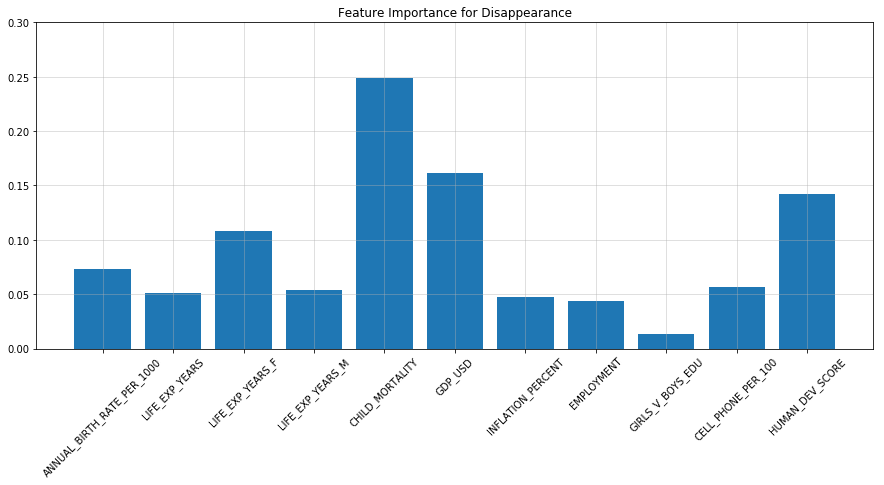

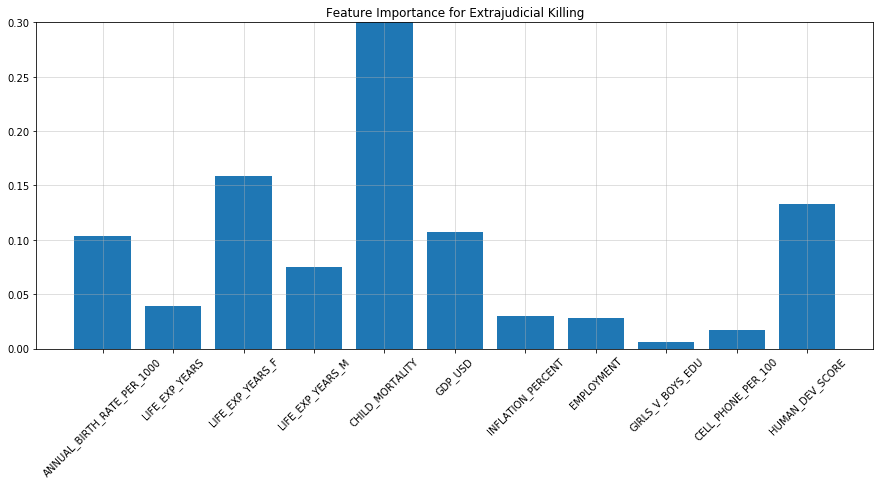

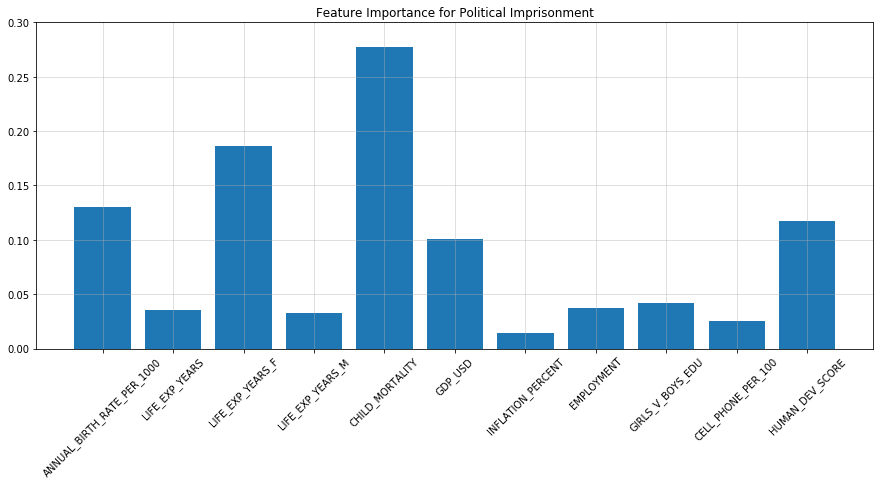

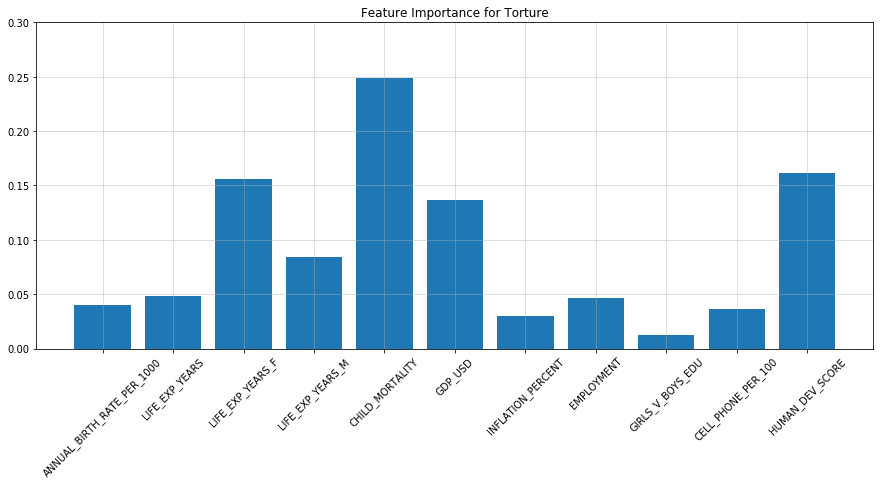

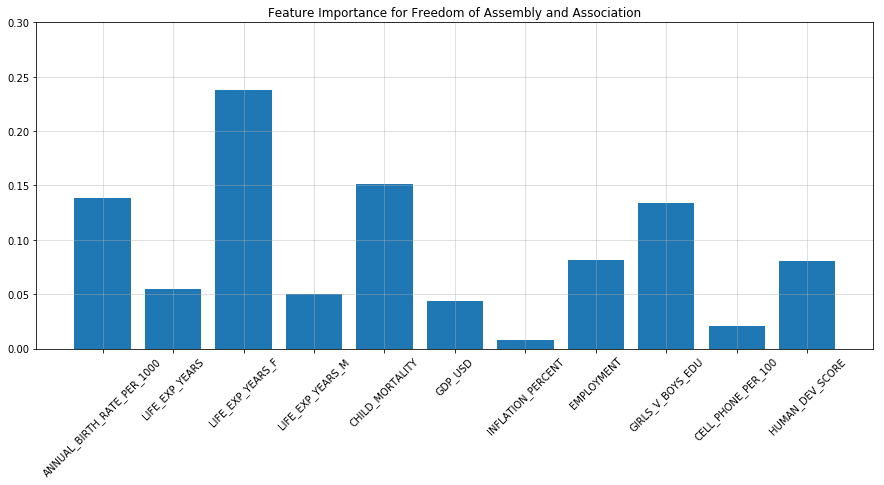

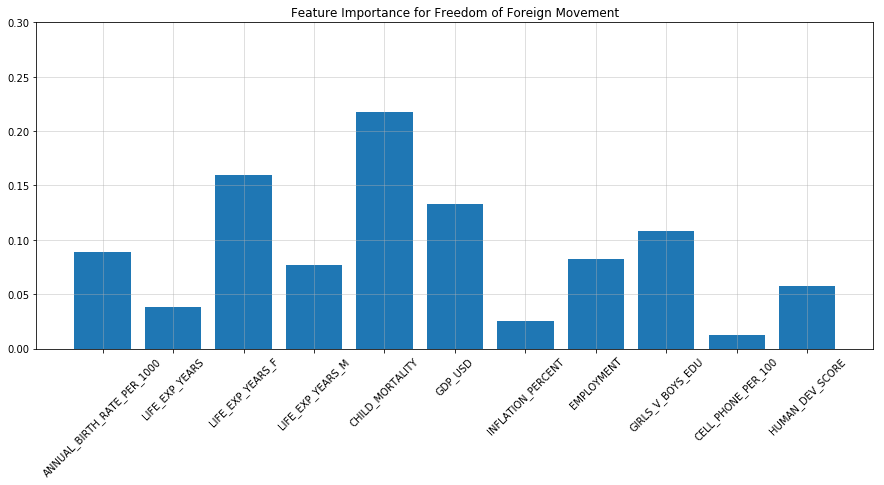

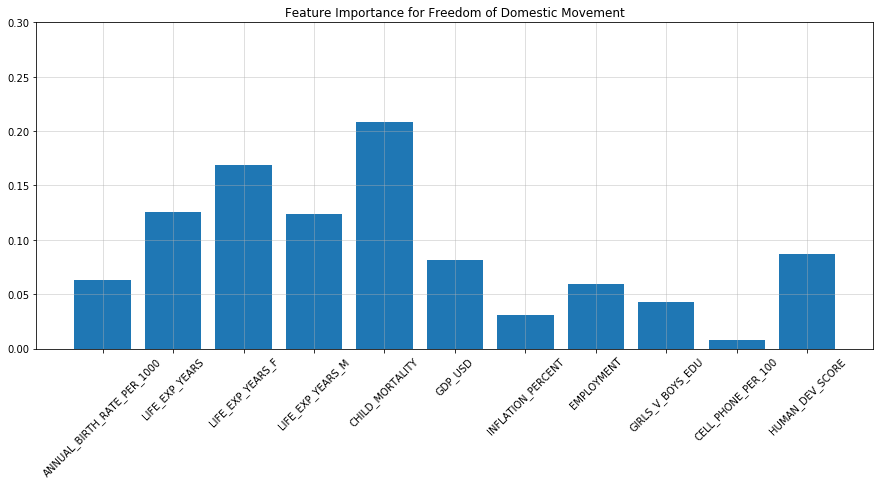

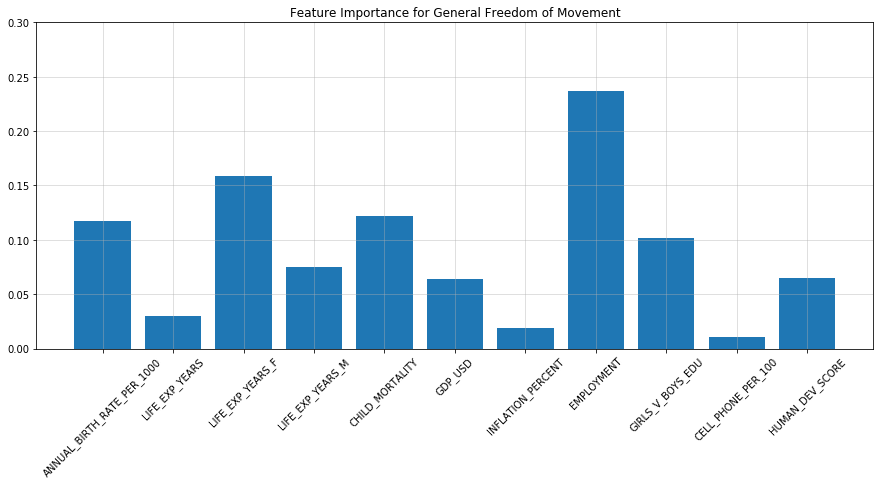

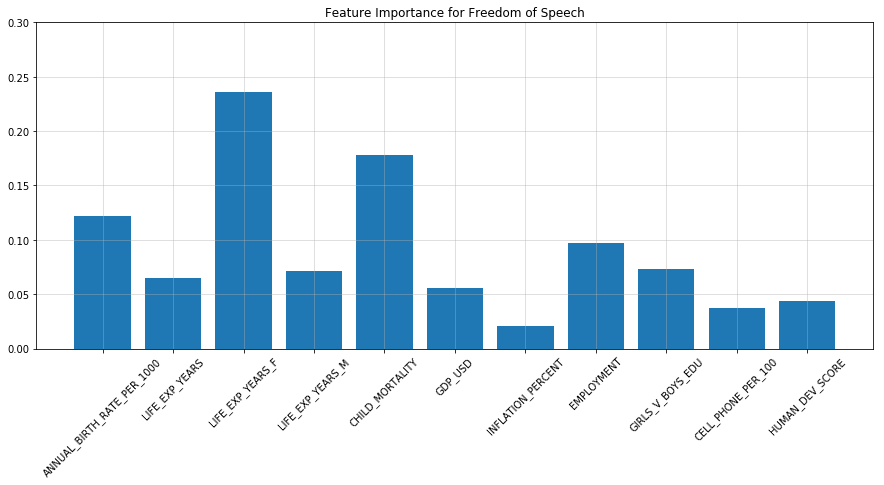

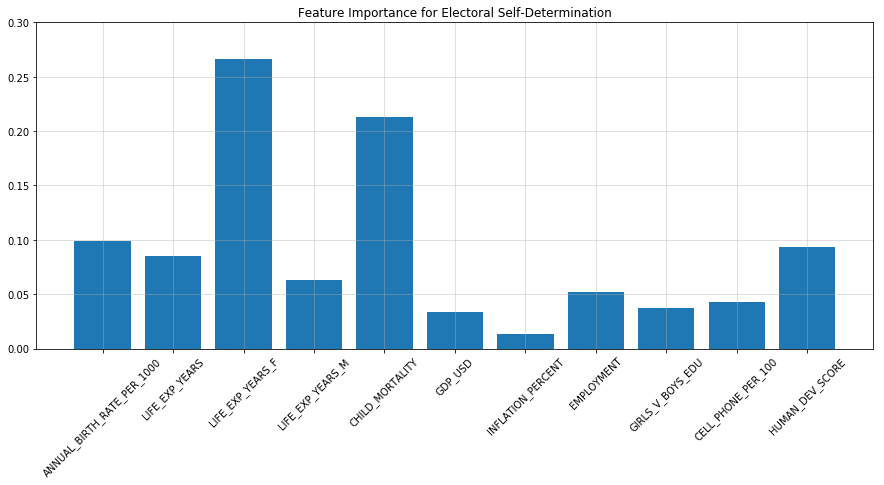

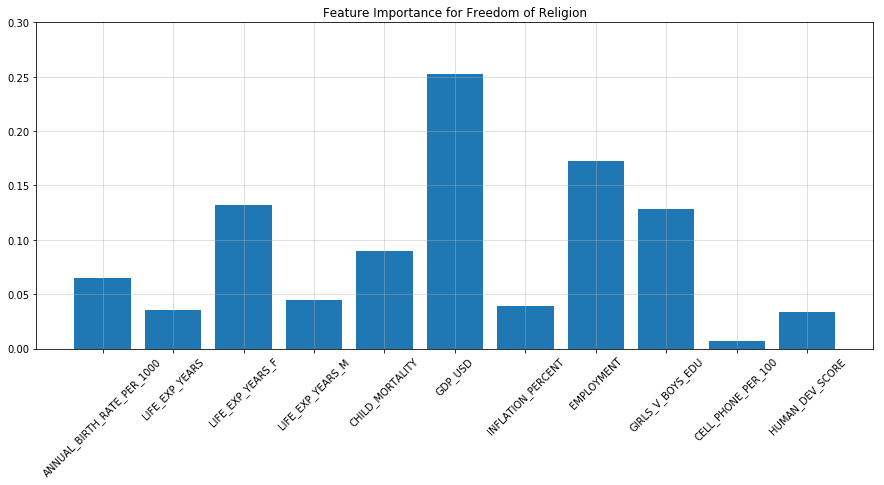

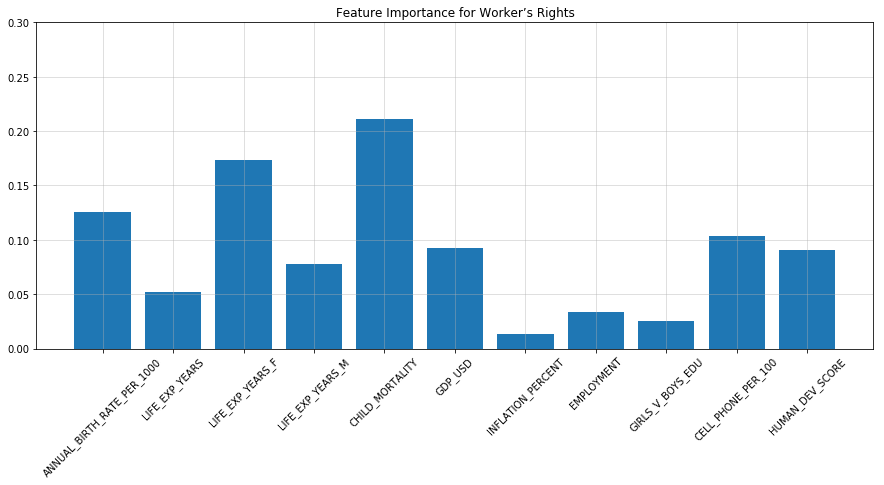

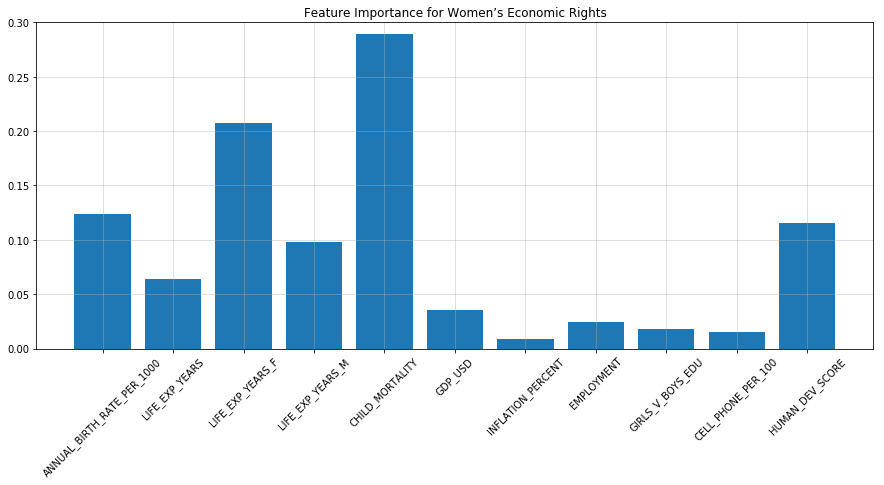

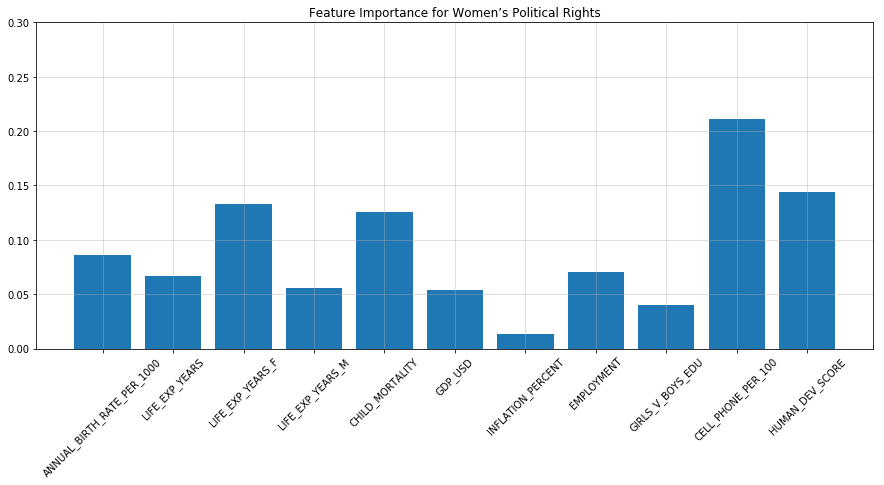

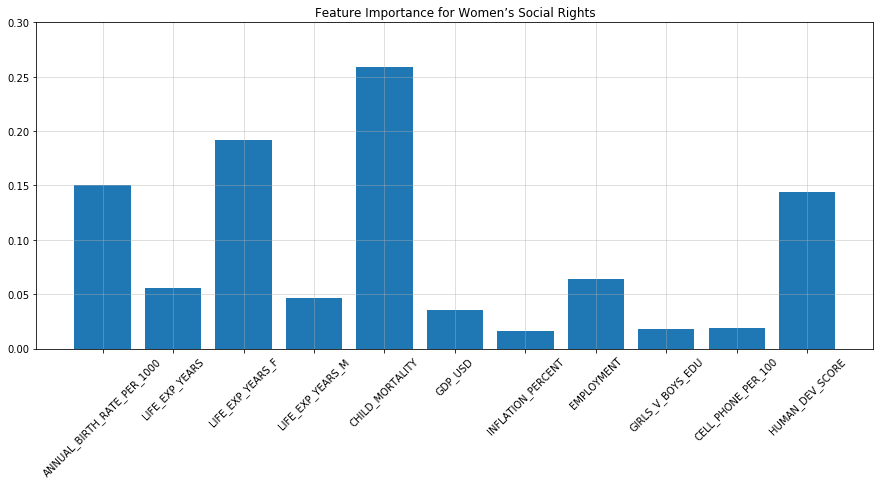

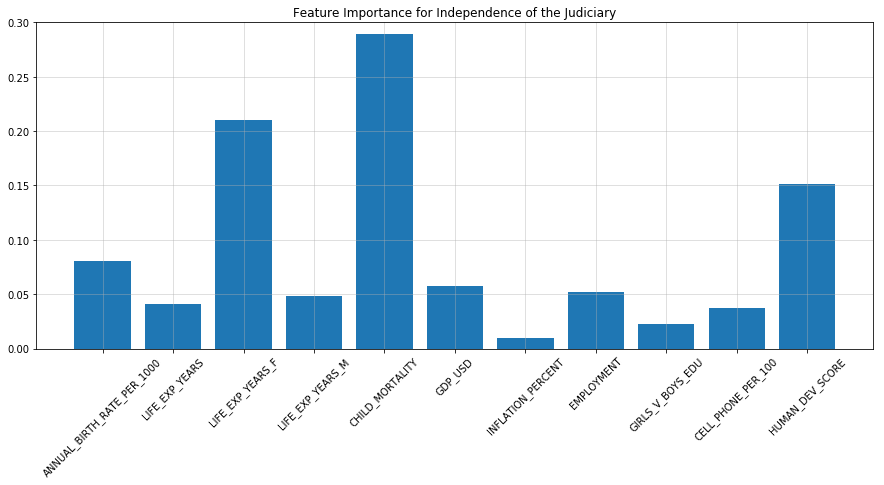

In [34]:
for i, lab in enumerate(index_interest):
    reduced_comb = comb_refined.dropna(subset=[lab],how='any')
    X_train, X_test, y_train, y_test = train_test_split(reduced_comb[rev_labels[1:-17]],\
                                                        reduced_comb[lab],\
                                                        test_size=0.20, random_state=68)
    clf.fit(X_train, y_train)
    out_clf = clf.predict(X_test)
    score = f1_score(y_test,out_clf,average='weighted')
    print('The F1 score is {} for '.format(round(score,3))+lab) 
    
    fig, ax = plt.subplots(figsize=(15,6))
    plt.grid(alpha=0.5)
    feature_importance = [w for w in clf.feature_importances_]
    plt.bar(rev_labels[1:-17],feature_importance)
    plt.xticks(rotation=45)
    plt.title('Feature Importance for '+ plot_labels[i])
    plt.ylim([0,0.3])